In [1]:
from helpers import *

In [2]:
df = pd.read_csv("rfm_and_delay_undersample.csv")
print(df.shape)
df.head()

(5994, 6)


,recency_score,frequency_score,monetary_score,rfm_score,avg_satisfaction,avg_delivery_delay
0,1,1,2,112,4.0,1.0
1,3,1,2,312,5.0,10.0
2,4,1,5,415,2.0,27.0
3,5,1,3,513,5.0,5.0
4,4,1,2,412,5.0,20.0


## TSNE

In [17]:
df

,recency_score,frequency_score,monetary_score,rfm_score,avg_satisfaction,avg_delivery_delay
0,1,1,2,112,4.000000,1.000000
1,3,1,2,312,5.000000,10.000000
2,4,1,5,415,2.000000,27.000000
3,5,1,3,513,5.000000,5.000000
4,4,1,2,412,5.000000,20.000000
...,...,...,...,...,...,...
5989,5,5,3,553,3.000000,-1.000000
5990,1,5,2,152,3.000000,11.500000
5991,2,5,5,255,3.500000,36.000000
5992,2,5,3,253,4.333333,16.666667


In [18]:
tsne = TSNE(random_state=42)
X_tsne_pca = tsne.fit_transform(df)

Text(0.5, 1.0, 'TSNE without PCA')

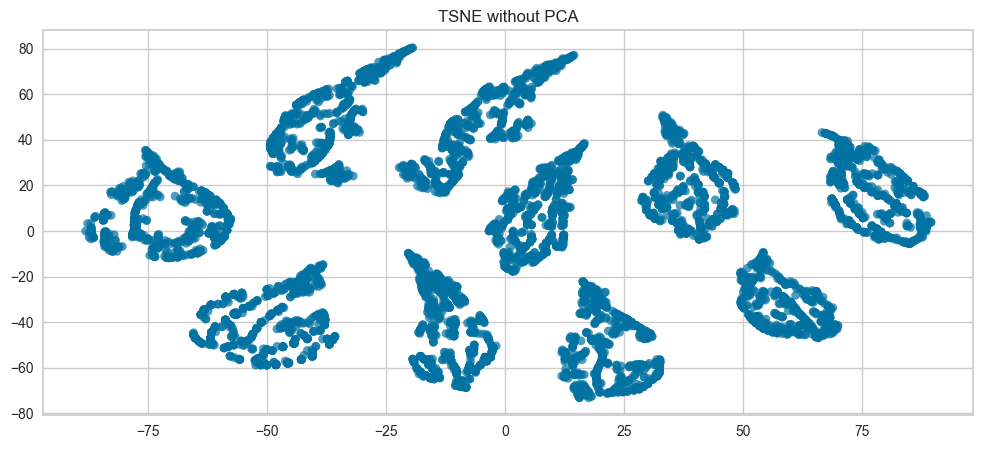

In [5]:
plt.figure(figsize=(12,5))
plt.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1],
            edgecolor='none', alpha=0.7, s=40)
plt.title('TSNE without PCA')

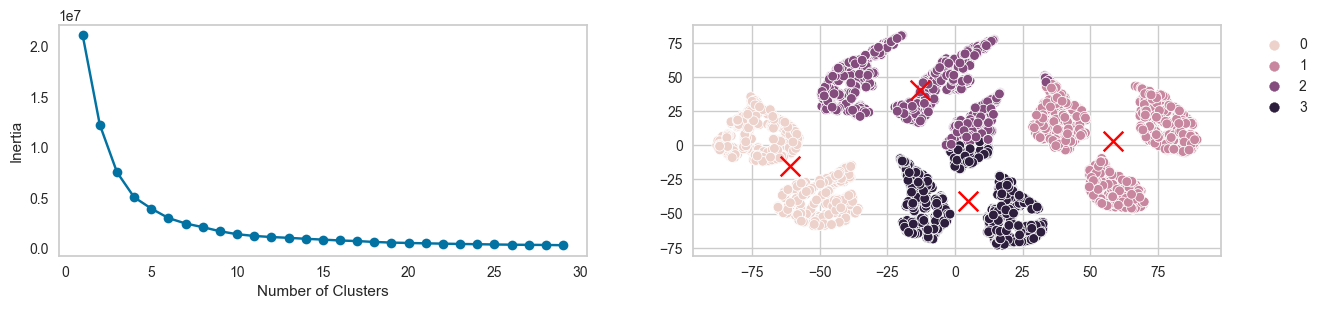

<Figure size 1000x300 with 0 Axes>

In [6]:
show_segmentation(X_tsne_pca, 4)

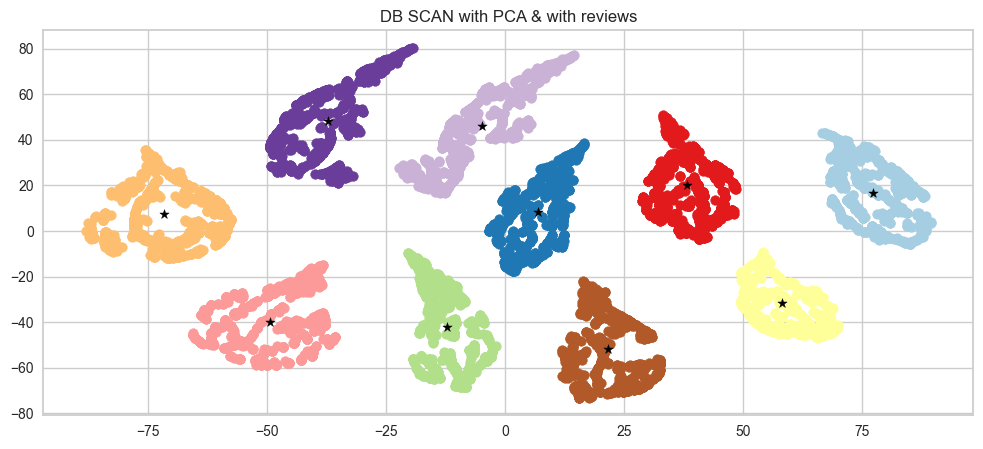

n_clusters 10


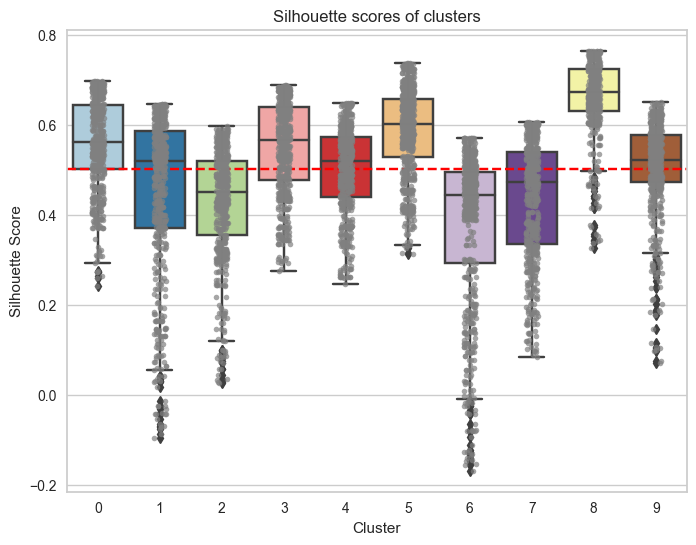

In [7]:
cluster_label = do_dbscan(X_tsne_pca, "DB SCAN with PCA & with reviews")

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


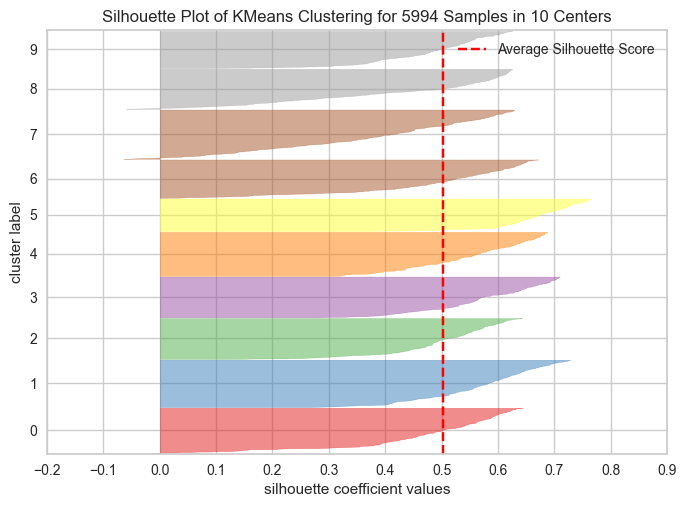

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 5994 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [8]:
# Instantiate the clustering model and visualizer 
model = KMeans(10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_tsne_pca)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

#### PCA Explainability (without review)

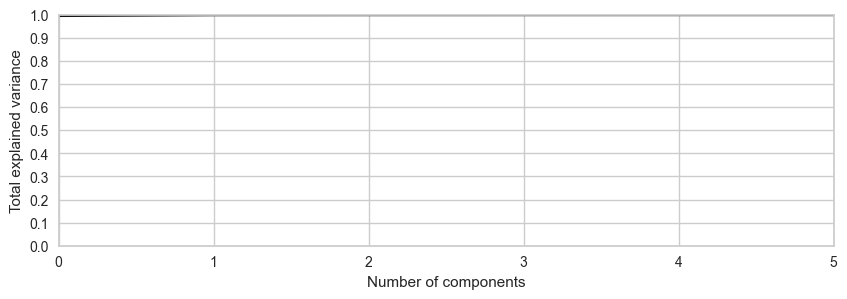

In [9]:
pca = PCA().fit(df)

plt.figure(figsize=(10,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 5)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [10]:
# perform PCA on the data  
pca = PCA(n_components=1)  
pca.fit(df)  
  
# get the loadings for the first principal component  
loadings = pca.components_[0]  
  
# create a dataframe to display the loadings  
loadings_df = pd.DataFrame({'Feature': df.columns, 'Loading': loadings})  
loadings_df = loadings_df.sort_values('Loading', ascending=False)  
  
print(loadings_df)  

              Feature   Loading
5  avg_delivery_delay  0.006619
4    avg_satisfaction -0.000319
2      monetary_score -0.001298
1     frequency_score -0.002633
0       recency_score -0.009723
3           rfm_score -0.999926


In [11]:
explained_variance = pca.explained_variance_ratio_[0] # explained variance of the first principal component  
feature_contrib = loadings_df['Loading'].apply(lambda x: x**2)  
loadings_df["Contribution"] = round(feature_contrib / feature_contrib.sum() * explained_variance,5) 

In [12]:
loadings_df

,Feature,Loading,Contribution
5,avg_delivery_delay,0.006619,0.00004
4,avg_satisfaction,-0.000319,0.00000
2,monetary_score,-0.001298,0.00000
1,frequency_score,-0.002633,0.00001
0,recency_score,-0.009723,0.00009
3,rfm_score,-0.999926,0.99599


/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

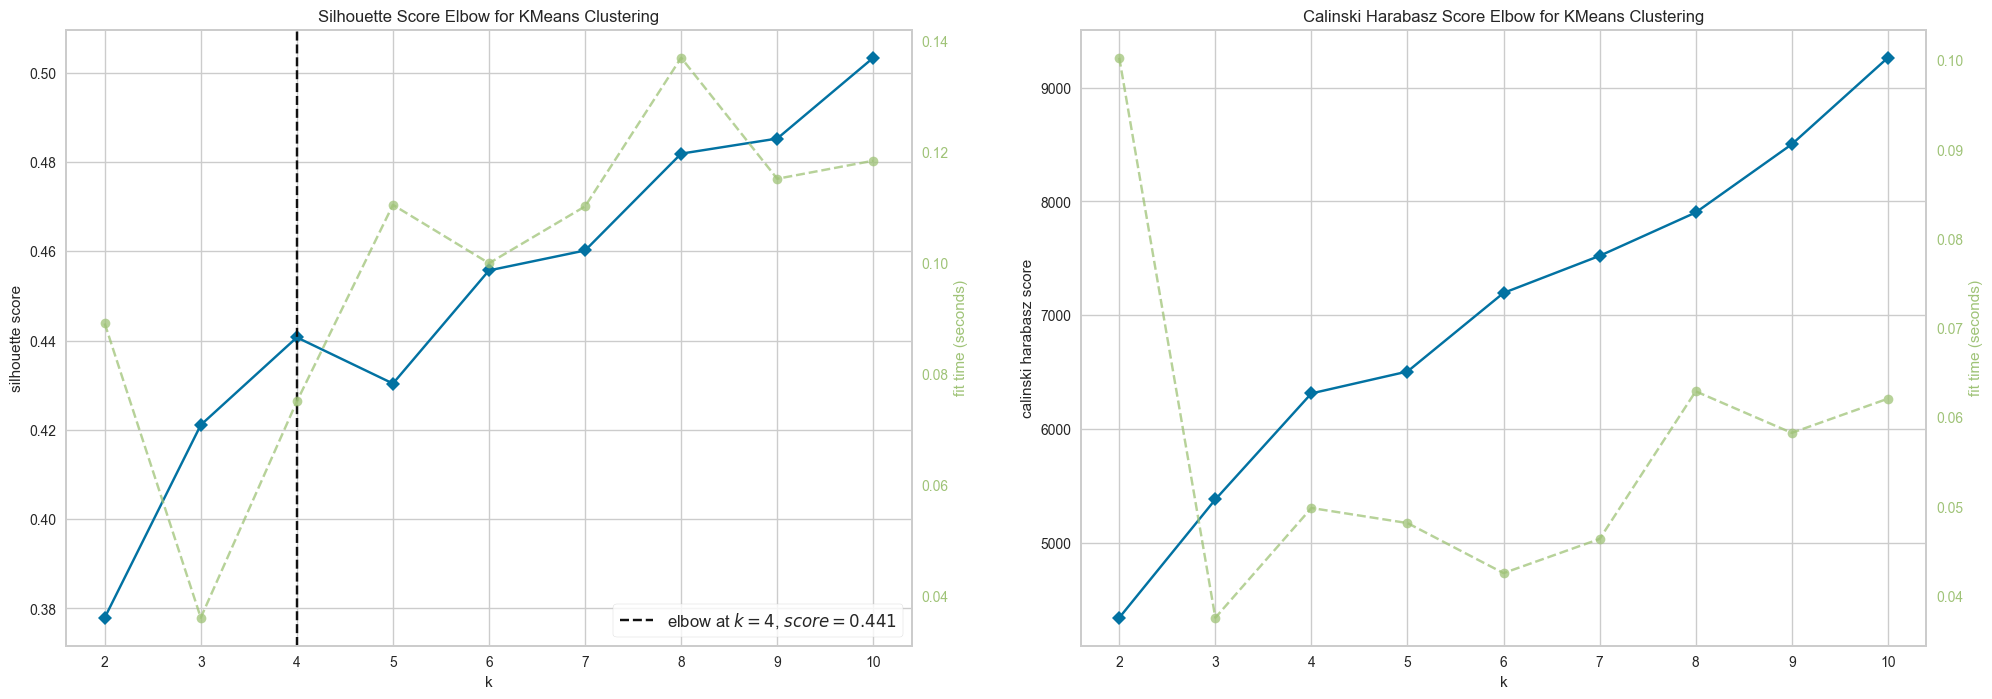

In [13]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.pipeline import Pipeline, make_pipeline

# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X_tsne_pca)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

In [30]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Clusters mean",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [31]:
X_tsne_pca

array([[ 82.156044 ,  -3.712189 ],
       [  9.830484 ,   2.0106044],
       [-16.710512 , -14.940513 ],
       ...,
       [ 16.55124  , -22.678764 ],
       [ 17.330296 , -35.557705 ],
       [ 57.257862 , -19.593073 ]], dtype=float32)

In [32]:
from sklearn.compose import ColumnTransformer, make_column_transformer

X_test = pd.DataFrame(df, index=df.index, columns=df.columns)
X_test["cluster_labels"] = cluster_label

X_test_clusters = X_test.groupby("cluster_labels").mean()
X_test_clusters

,recency_score,frequency_score,monetary_score,rfm_score,avg_satisfaction,avg_delivery_delay
cluster_labels,,,,,,
0,1.0,1.0,2.863946,112.863946,4.086735,11.943878
1,3.0,1.0,2.896839,312.896839,3.828619,14.093178
2,4.0,1.0,3.059028,413.059028,4.012153,11.904514
3,5.0,1.0,3.028346,513.028346,4.247244,7.905512
4,2.0,1.0,2.882747,212.882747,4.000000,12.338358
5,5.0,5.0,4.150805,554.150805,4.164419,8.915373
6,3.0,5.0,4.194662,354.194662,3.891462,13.985740
7,4.0,5.0,4.144246,454.144246,4.096704,11.859914
8,1.0,5.0,3.936170,153.936170,4.042199,10.922695


In [33]:
plot_radars(data=X_test_clusters, group="cluster_labels")